In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
import healpy as hp
import os
import kebab

# Definition of classes

## Healper class catalog_object

```catalog_object(ra,dec,flux_w1,flux_w2,nside)``` can initialize the object.

Use ```print(catalog_object)``` to print details.

Use ```get_neighbours(theta,nside)``` to query disk.

Use ```get_ymap_vals(theta,ymap,nside)```to return a ymap_list correponding to ```get_neighbours(theta, nside)```.

## Healper function read catalog

```read_catalog(catalogPath,ntest)```.

- When ntest is ```int```, reads first ```ntest``` samples.
- When ntest is ```tuple```, reads between interval.
- When ntest is ```list```, reads according to the list.

In [4]:
NSIDE = 2048

UNWISE = '/mnt/d/data_large/unwise_sz/unWISE/catalog/blue_fullsky/'
catalog_list = os.listdir(UNWISE)

CMBY = '/mnt/d/data_large/unwise_sz/CMB_ymap/Planck/ymap/'
cmb_list = os.listdir(CMBY)

class catalog_object:
    def __init__(self,ra = None,dec = None,flux_w1 = None,flux_w2 = None,nside = NSIDE):
        
        self.ra = ra
        self.dec = dec
        self.fix_coords()
        
        self.flux_w1 = flux_w1
        self.flux_w2 = flux_w2
        self.pix = hp.ang2pix(nside, self.l, self.b, lonlat=True)
    
    def __repr__(self):
        return 'ra: {}, dec: {}, l: {}, b: {}, flux_w1: {}, flux_w2: {}, pix: {}'.format(self.ra, self.dec, self.l, self.b, self.flux_w1, self.flux_w2, self.pix)
    
    def fix_coords(self):
        self.coords = SkyCoord(ra=self.ra*u.degree, dec=self.dec*u.degree, frame='icrs')
        self.l, self.b = self.coords.galactic.l.value, self.coords.galactic.b.value
        return None
        
    def get_neighbours(self,angle_distance_deg, nside=NSIDE):
        angular_distance = np.radians(angle_distance_deg)
        neighbour_pix = hp.query_disc(nside, hp.ang2vec(self.l, self.b, lonlat=True), angular_distance)
        return neighbour_pix

    def get_ymap_vals(self,angle_distance_deg,ymap=None,nside=NSIDE):
        if ymap is None:
            return None
        else:
            neighbour_pixels = self.get_neighbours(angle_distance_deg, nside=nside)
            return ymap[neighbour_pixels]
    
    def get_pixel_vals_hist(self,angle_distance_deg,ymap=None,nside=NSIDE,nbins=100):
        pixels = self.get_neighbours(angle_distance_deg,nside=nside)
        values = self.get_ymap_vals(angle_distance_deg,ymap=ymap,nside=nside)
        centre_pixel = self.pix
        return self.cast_values_2d(pixels,centre_pixel,values,nbins=nbins)
    
    def cast_values_2d(self,pixels,centre_pixel,values,nbins = 100):
        vec_centre = hp.pix2vec(NSIDE,centre_pixel)
        vecs = hp.pix2vec(NSIDE,pixels)

        # set x axis perpendicular to the centre pixel
        x_axis = np.cross(vec_centre,[0,0,1])
        x_axis = x_axis/np.linalg.norm(x_axis)
        
        # set y axis perpendicular to the centre pixel and the x axis
        y_axis = np.cross(vec_centre,x_axis)
        y_axis = y_axis/np.linalg.norm(y_axis)
        
        # project the vectors onto the x and y axes
        x_projections = np.dot(x_axis,vecs)
        y_projections = np.dot(y_axis,vecs)
        
        # create a 2d histogram
        hist, xedges, yedges = np.histogram2d(x_projections, y_projections, bins=nbins, weights=values)
        
        # get the bin centers
        xcenters = (xedges[:-1] + xedges[1:]) / 2
        ycenters = (yedges[:-1] + yedges[1:]) / 2
        
        return xcenters, ycenters, hist.T
    


def read_catalog(catalogPath,ntest = None):
    try:
        catalog = fits.open(catalogPath)[1].data
    except:
        print('Error reading catalog: ', catalogPath)
        return None
    
    ra = catalog['ra']
    dec = catalog['dec']
    
    flux_w1 = catalog['flux_w1']
    flux_w2 = catalog['flux_w2']
    
    # yield a iterable object containing the catalog objects
    # if ntest is interval (a,b) then it will return objects from a to b
    # if ntest is a number it will return the first ntest objects
    
    if ntest is None:
        ntest = range(len(ra))
    elif isinstance(ntest,list):
        pass
    elif isinstance(ntest,tuple):
        a,b = ntest
        ntest = range(a,b)
    elif isinstance(ntest,int):
        ntest = range(ntest)
    
    for i in ntest:
        yield catalog_object(ra[i], dec[i], flux_w1[i], flux_w2[i])


## testing of coordinate conversion

In [18]:
def galactic_to_cartesian(l, b):
    # Convert galactic coordinates to a 3D unit vector
    l_rad = np.radians(l)
    b_rad = np.radians(b)
    
    x = np.cos(b_rad) * np.cos(l_rad)
    y = np.cos(b_rad) * np.sin(l_rad)
    z = np.sin(b_rad)
    
    return np.array([x, y, z])

# Manual conversion
l, b = 120.0, -30.0  # galactic coordinates
vec_manual = galactic_to_cartesian(l, b)

# Healpy conversion
vec_healpy = hp.ang2vec(l, b, lonlat=True)

print("Manual Cartesian:", vec_manual)
print("Healpy Cartesian:", vec_healpy)


Manual Cartesian: [-0.4330127  0.75      -0.5      ]
Healpy Cartesian: [-0.4330127  0.75      -0.5      ]


In [42]:
unwise_catalog_0 = read_catalog(UNWISE + catalog_list[0],1)
for catalog_obj in unwise_catalog_0:
    neighbours = catalog_obj.get_neighbours(0.1)
    print(neighbours)
    print(catalog_obj.get_ymap_vals(0.1,ymap=None))

[7459902 7459903 7459904 7467628 7467629 7467630 7467631 7467632 7475359
 7475360 7475361 7475362 7475363 7475364 7483094 7483095 7483096 7483097
 7483098 7483099 7490833 7490834 7490835 7490836 7490837 7490838 7498577
 7498578 7498579 7498580 7498581 7498582 7506324 7506325 7506326 7506327
 7506328 7514077 7514078 7514079]
None


## Read the Ymap for stacking y retrieval

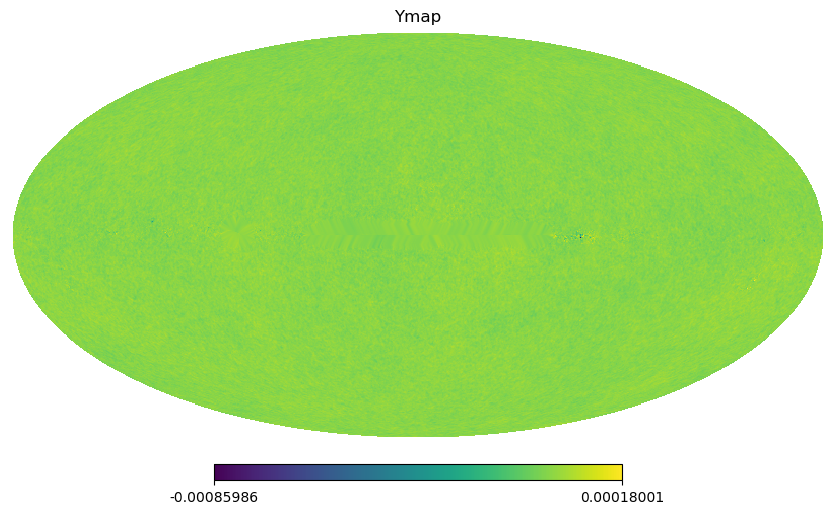

In [5]:
ymap_path = kebab.CMBY+kebab.cmb_list[0]
ymap = hp.read_map(ymap_path)
hp.mollview(ymap, title = 'Ymap',cbar = True)

## The ymap retrieval code

3833 3833
3835 3835
3833 3833
3837 3837
3828 3828
3830 3830
3839 3839
3837 3837
3833 3833
3832 3832


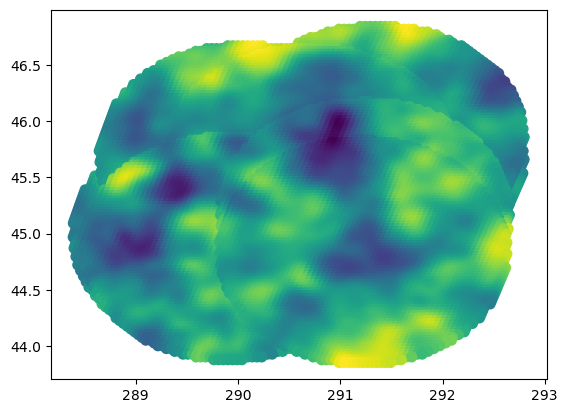

In [6]:
ntest = np.random.choice(range(5000),10)
angle = 1

unwise_catalog_0 = read_catalog(UNWISE + catalog_list[0],ntest)
for catalog_obj in unwise_catalog_0:
    neighbours = catalog_obj.get_neighbours(angle)
    # print(catalog_obj.pix in neighbours)
    yvals = catalog_obj.get_ymap_vals(angle,ymap=ymap)
    print(len(neighbours),len(yvals))
    l,b = hp.pix2ang(NSIDE,neighbours,lonlat=True)
    plt.scatter(l, b, c=yvals,s = 50)


In [85]:
# def cast_values_2d(pixels,centre_pixel,values,nbins = 100):
#     vec_centre = hp.pix2vec(NSIDE,centre_pixel)
#     vecs = hp.pix2vec(NSIDE,pixels)

#     # set x axis perpendicular to the centre pixel
#     x_axis = np.cross(vec_centre,[0,0,1])
#     x_axis = x_axis/np.linalg.norm(x_axis)
    
#     # set y axis perpendicular to the centre pixel and the x axis
#     y_axis = np.cross(vec_centre,x_axis)
#     y_axis = y_axis/np.linalg.norm(y_axis)
    
#     # project the vectors onto the x and y axes
#     x_projections = np.dot(x_axis,vecs)
#     y_projections = np.dot(y_axis,vecs)
    
#     # create a 2d histogram
#     hist, xedges, yedges = np.histogram2d(x_projections, y_projections, bins=nbins, weights=values)
    
#     # get the bin centers
#     xcenters = (xedges[:-1] + xedges[1:]) / 2
#     ycenters = (yedges[:-1] + yedges[1:]) / 2
    
#     return xcenters, ycenters, hist.T

# def plot_2d(pixels,centre_pixel,values,nbins = 100):
#     x_c, y_c, hist = cast_values_2d(pixels,centre_pixel,values,nbins = nbins)
#     plt.pcolormesh(x_c, y_c, hist, cmap='viridis')
#     plt.colorbar()
#     plt.show()

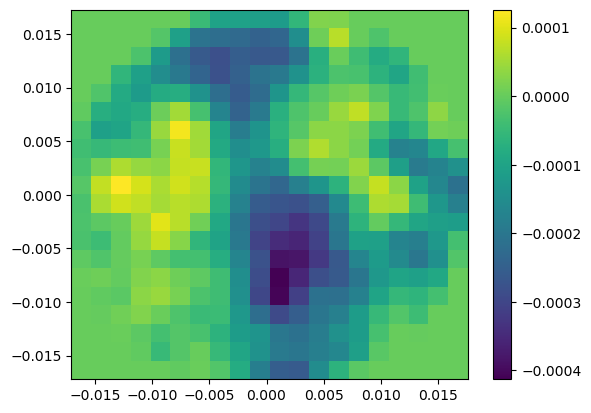

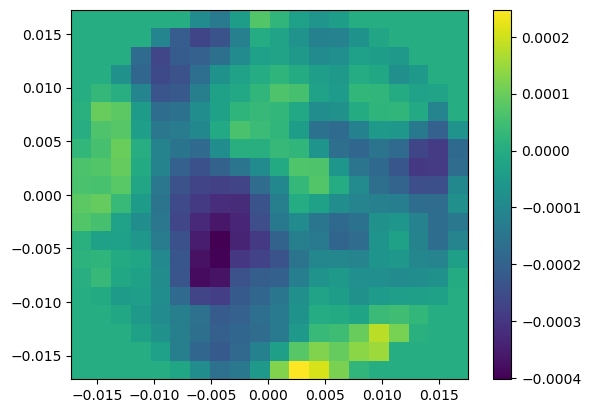

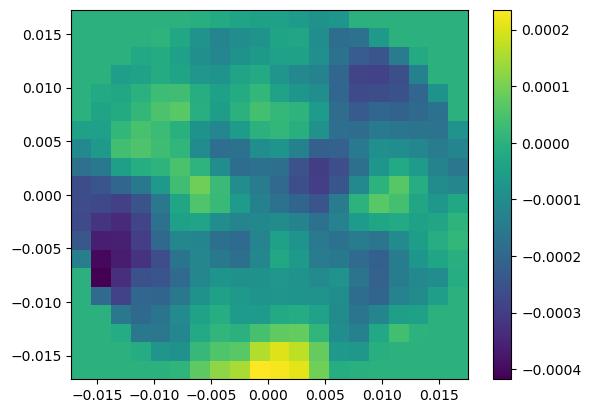

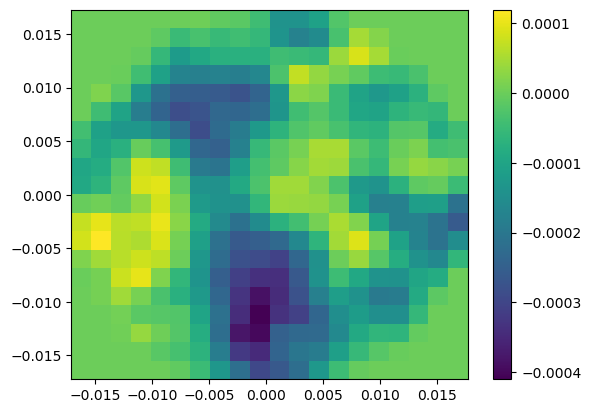

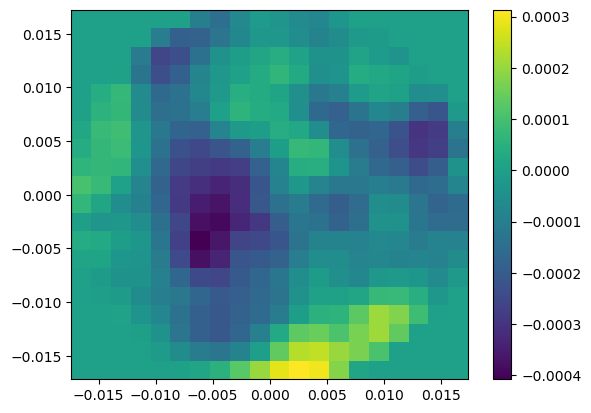

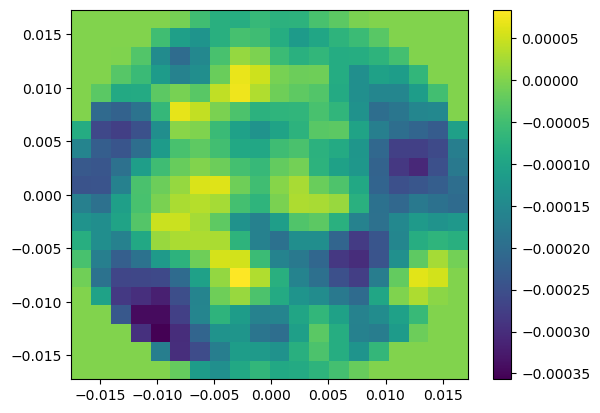

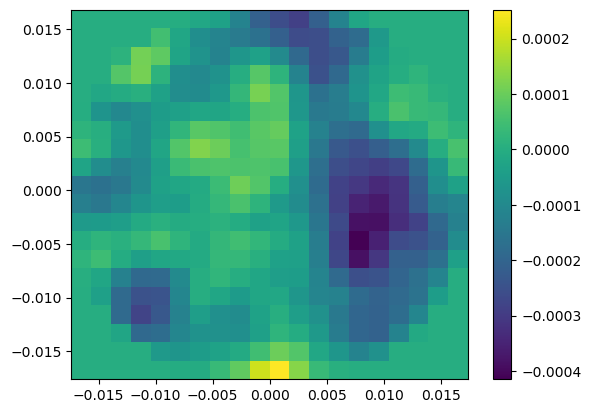

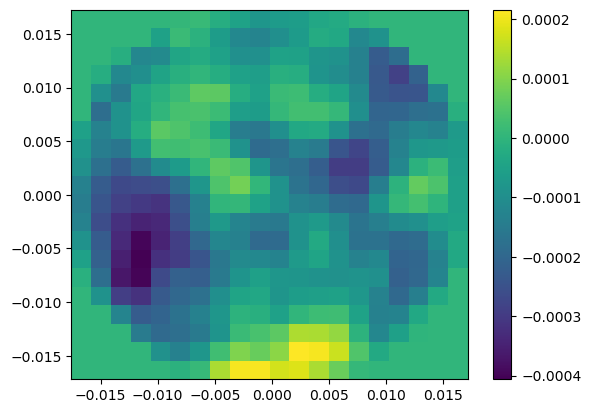

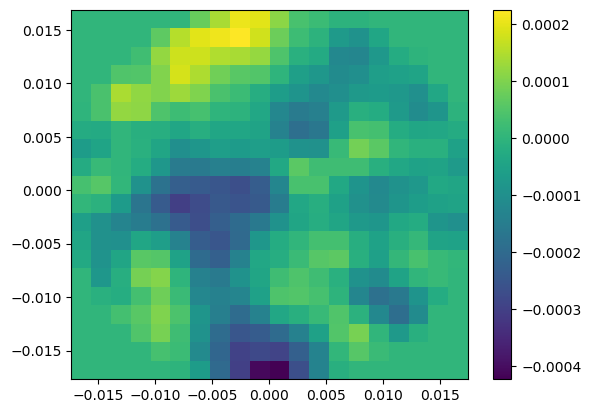

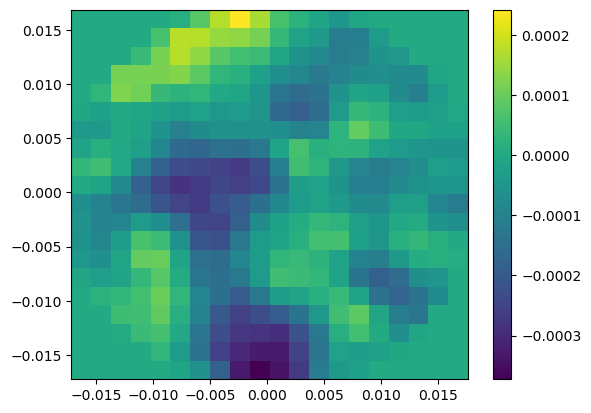

In [7]:
ntest = np.random.choice(range(5000),10)
angle = 1

unwise_catalog_0 = read_catalog(UNWISE + catalog_list[0],ntest)
for catalog_obj in unwise_catalog_0:
    x_c,y_c,hist = catalog_obj.get_pixel_vals_hist(angle,ymap=ymap,nbins=20)
    plt.pcolormesh(x_c, y_c, hist, cmap='viridis')
    plt.colorbar()
    plt.show()

## Stackmap Test

In [16]:
ntest = np.random.choice(range(100000),2000)
angle = 2
nbins = 50

ymap_path = kebab.CMBY+kebab.cmb_list[0]
ymap = hp.read_map(ymap_path)
print('ymap loaded')

unwise_catalog_0 = read_catalog(UNWISE + catalog_list[0],ntest)
hist = np.zeros((nbins,nbins))
stds = np.zeros((nbins,nbins))

i = 0
for catalog_obj in unwise_catalog_0:
    x_c,y_c,hist_permap = catalog_obj.get_pixel_vals_hist(angle,ymap=ymap,nbins=nbins)
    hist += hist_permap
    stds += hist_permap**2
    i += 1
    print('stack complete for {}'.format(i),end='\r')

ymap loaded


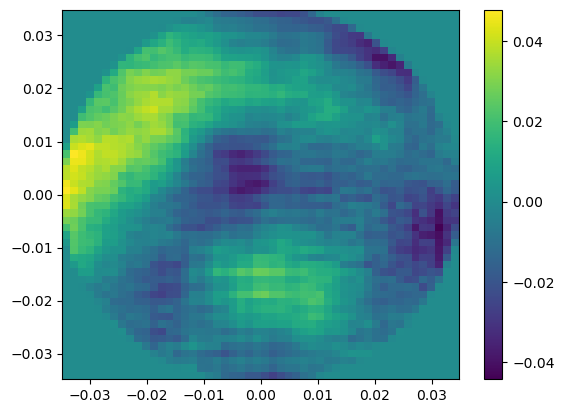

In [17]:
plt.pcolormesh(x_c, y_c, hist, cmap='viridis')
plt.colorbar()
plt.show()

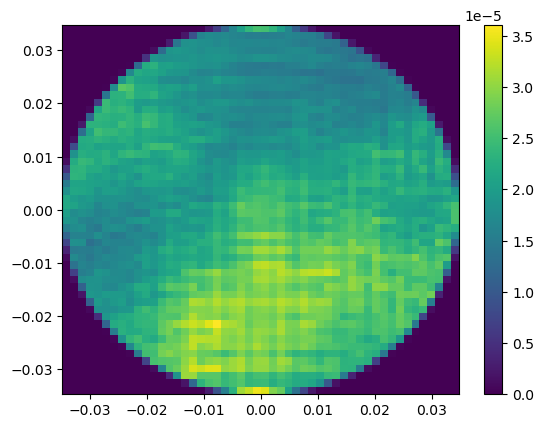

In [18]:
plt.pcolormesh(x_c, y_c, stds, cmap='viridis')
plt.colorbar()
plt.show()

# Stacking Code Kebab

In [2]:
path_catalog_list = kebab.catalog_list
catalog_base = kebab.read_catalog(kebab.UNWISE+path_catalog_list[0])

In [54]:
ntests = 1000
catalog_test = kebab.test_catalog(catalog_base,1000)

ra = catalog_test['ra'][1]
dec = catalog_test['dec'][1]
coords = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
l, b = coords.galactic.l.value, coords.galactic.b.value

print('ra:',ra)
print('dec:',dec)
print('l:',l)
print('b:',b)

print(catalog_test['l'][1],catalog_test['b'][1])

ra: 82.69060162608261
dec: 13.907030705803036
l: 191.0195008776144
b: -10.851734803582442
191.0195008776144 -10.851734803582442


In [55]:
pix = hp.ang2pix(kebab.NSIDE,l,b,lonlat=True)
print('pix:',pix)
pix_disk = kebab.get_pixel_around_centre(l,b,nside = kebab.NSIDE)
print('pix_disk:',pix_disk['pix'])
print(pix in pix_disk['pix'])

pix: 29901050
pix_disk: [29475064 29475065 29475066 ... 30327036 30327037 30327038]
True


In [61]:
projection_catalogs = []
for i in range(ntests):
    l,b = catalog_test['l'][i],catalog_test['b'][i]
    proj_catalog = kebab.get_pixel_around_centre(l,b,nside = kebab.NSIDE)
    pix_centre = hp.ang2pix(kebab.NSIDE,l,b,lonlat=True)
    projection_catalogs.append(proj_catalog)

In [64]:
l,b = catalog_test['l'][1],catalog_test['b'][1]
pix_centre = hp.ang2pix(kebab.NSIDE,l,b,lonlat=True)
print(pix_centre in projection_catalogs[1]['pix'])

True


True


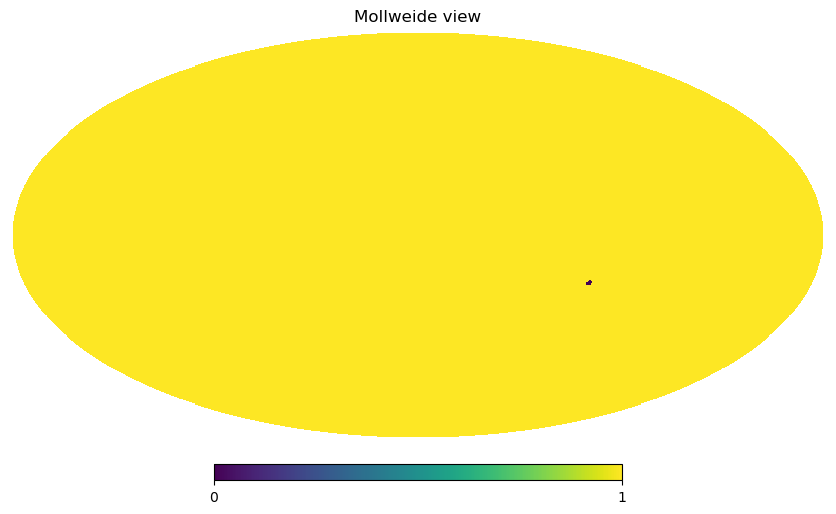

In [72]:
testarr = np.ones(hp.nside2npix(2048))

l,b = catalog_test['l'][0],catalog_test['b'][0]
pix_centre = hp.ang2pix(kebab.NSIDE, l, b, lonlat=True)

pix_disk = projection_catalogs[0]['pix']

testarr[pix_disk] = 0
testarr[pix_centre] = 2

print(pix_centre in pix_disk)
hp.mollview(testarr)

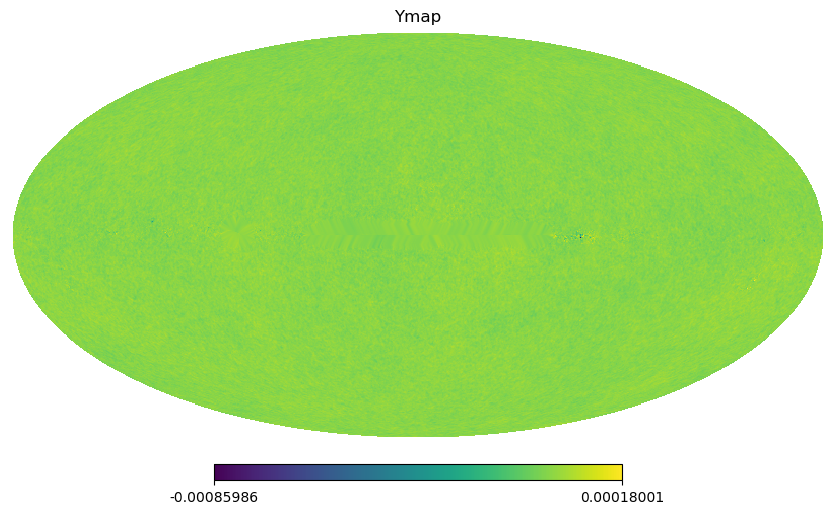

In [73]:
ymap_path = kebab.CMBY+kebab.cmb_list[0]
ymap = hp.read_map(ymap_path)
hp.mollview(ymap, title = 'Ymap',cbar = True)

In [78]:
for proj_catalog in projection_catalogs:
    ymap_pix = proj_catalog['pix']
    ymap_values = ymap[ymap_pix]
    proj_catalog['ymap'] = ymap_values


In [79]:
counts,ystack = kebab.stack_yvalue(projection_catalogs,100,1.0)

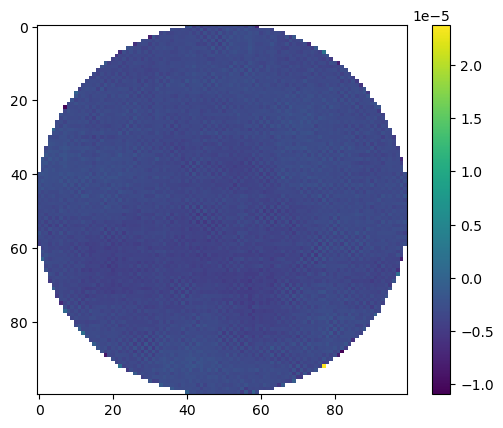

In [83]:
plt.imshow(ystack,aspect = 'equal',cmap = 'viridis')
plt.colorbar()

Well this is disappoiniting...